# Group 7 - MAPD-B PROJECT: Distributed algorithms
## K-Means: Minibatch using pyspark
Team members: Ausilio Lorenzo, Jafarpour Farshad, Martemucci Walter, Prodan George

### Initialize spark, imports 

In [1]:
import findspark
findspark.init('/usr/local/spark/')

In [2]:
# check some of the env variables
!env | grep -i spark

VIRTUAL_ENV=/usr/local/environments/spark_env
PYSPARK_PYTHON=/usr/local/environments/spark_env/bin/python3
SPARK_HOME=/usr/local/spark/
PATH=/usr/local/environments/spark_env/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/local/spark/bin


In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

master_url = "spark://10.67.22.172:7077"

# conf = SparkConf()

# conf.setAppName("KMeansMiniBatch")
# conf.set("spark.blockManager.port", "10025")
# conf.set("spark.driver.blockManager.port", "10026")
# conf.set("spark.driver.port", "10027")  
# conf.set("spark.cores.max", "12") 
# conf.set("spark.executor.memory", "2g") 
# conf.set("spark.driver.host", "10.67.22.172"); 
# conf.setMaster(master_url)

spark = SparkSession.builder \
        .master(master_url)\
        .config("spark.blockManager.port", "10025")\
        .config("spark.driver.blockManager.port", "10026")\
        .config("spark.driver.port", "10027")\
        .config("spark.cores.max", "12")\
        .config("spark.executor.memory", "6g")\
        .config("spark.driver.host", "10.67.22.172")\
        .appName("KMeansApp")\
        .getOrCreate()




Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/18 13:26:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Check the content of the SparkSession `spark` object

In [2]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.172:7077 appName=KMeansApp>

In [3]:
import numpy as np
import time 
from matplotlib import pyplot as plt 
import time
import numpy
import os

In [66]:
os.environ["PYSPARK_PYTHON"]="/usr/local/environments/spark_env/bin/python3"

In [4]:
def find_min(idx):
    distances = [np.linalg.norm(X[idx] - centroid, 2) for centroid in C]
    return np.argmin(distances)

In [5]:
def kmeans(use_spark=True, no_clusters=3, steps=1000, batch_size=400000):
    
    # 1: Given: k, mini-batch size b, iterations t, data set X
    # 2: Initialize each c ∈ C with an x picked randomly from X
    # 3: v ← 0
    k = no_clusters
    b = batch_size
    t = steps
    C = np.array([X[np.random.randint(0, len(X))] for _ in range(k)])
    v = np.zeros(len(C))
    Y = np.empty(len(X), dtype=np.int32)
    
    tic = time.time()
    
    for i in range(t):
            # 4: for i = 1 to t do
            # 5: M ← b examples picked randomly from X
            mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)

            # 6: for x ∈ M do
            # 7: d[x] ← f (C, x) // Cache the center nearest to x
            # 8: end for
            # 9: for x ∈ M do
            # 10: c ← d[x] // Get cached center for this x
            # 11: v[c] ← v[c] + 1 // Update per-center counts
            # 12: η ← 1/v[c] // Get per-center learning rate
            # 13: c ← (1 − η)c + ηx // Take gradient step
            # 14: end for
            # 15: end for

            if use_spark:
                mini_batch = X[mini_batch_idx]
                dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
                Y[mini_batch_idx] = dist_mini_batch_idx.map(
                                    lambda idx: np.argmin((C[:,0] - X[idx][0]) ** 2 + (C[:,1] - X[idx][1]) ** 2)
                                    ).collect()
            else:    
                # this is the classic implementation (https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)
                for idx in mini_batch_idx:
                    Y[idx] = find_min(idx)
            for idx in mini_batch_idx:
                v[Y[idx]] += 1
                learning_rate = 1 / v[Y[idx]]
                C[Y[idx]] = (1 - learning_rate) * C[Y[idx]] + learning_rate * X[idx]

    toc = time.time()
    print('Computation time: ', toc - tic, ' seconds')
    return Y

### Experiment #1: random sampling on three distributions

Firstly, we have created a mock dataset in order to do several fast tests on the algorithm.

In [68]:
# generate mock dataset
c_1 = np.random.normal(0.5, 0.2, (1000000, 2))
c_2 = np.random.normal(1.0, 0.2, (1000000, 2))
c_3 = np.random.normal(-0.5, 0.2, (1000000, 2))
X = np.concatenate((c_1,c_2,c_3))

In [69]:
k = 3
b = 500000
t = 1000
C = np.array([X[np.random.randint(0, len(X))] for _ in range(k)])
v = np.zeros(len(C))
Y = np.empty(len(X), dtype=np.int32)

In [70]:
mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)

tic = time.time()
for idx in mini_batch_idx:
    Y[idx] = find_min(idx)
toc = time.time()
print('time find centroids (classic):', toc - tic)


mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)
tic = time.time()
mini_batch = X[mini_batch_idx]
dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
Y[mini_batch_idx] = dist_mini_batch_idx.map(lambda idx: np.argmin((C[:,0] - X[idx][0]) ** 2 + (C[:,1] - X[idx][1]) ** 2)).collect()
toc = time.time()
print('time find centroids (by spark):', toc - tic)


time find centroids (classic): 9.117126226425171


22/06/15 15:22:28 WARN TaskSetManager: Stage 220 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.


time find centroids (by spark): 2.862954616546631


In [72]:
Y = kmeans(use_spark=True, steps=10)

Computation time:  55.02375936508179  seconds


In [71]:
Y = kmeans(use_spark=False, steps=10)

Computation time:  104.32673597335815  seconds


In [1]:
plt.plot(Y)
plt.ylim((-3,3))
plt.show()

NameError: name 'plt' is not defined

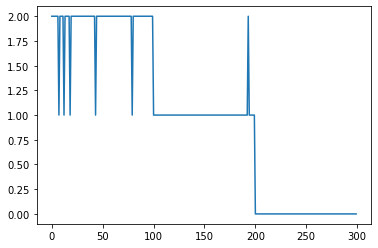

22/06/11 13:45:35 WARN HeartbeatReceiver: Removing executor 0 with no recent heartbeats: 67310777 ms exceeds timeout 120000 ms
22/06/11 13:45:35 ERROR TaskSchedulerImpl: Lost executor 0 on 192.168.144.128: Executor heartbeat timed out after 67310777 ms


In [86]:
plt.plot(Y)

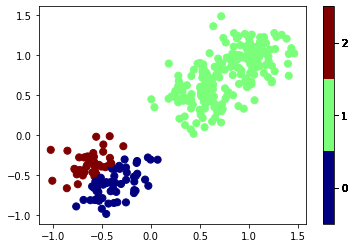

In [82]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors

# Define a colormap with the right number of colors
cmap = plt.cm.get_cmap('jet',max(Y)-min(Y)+1)

bounds = range(min(Y),max(Y)+2)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X[:,0], X[:,1], c=Y, s=50, cmap=cmap, norm=norm)

# Add a colorbar. Move the ticks up by 0.5, so they are centred on the colour.
cb=plt.colorbar(ticks=np.array(Y)+0.5)
cb.set_ticklabels(Y)

plt.show()

### RCV1 dataset loading

In [6]:
from sklearn.datasets import fetch_rcv1

rcv1 = fetch_rcv1()
X_train = rcv1.data[0:23149]
X_test = rcv1.data[23149:]
y_train = rcv1.target[0:23149].toarray()
y_test = rcv1.target[23149:].toarray()

In [28]:
len(np.unique(y_train, axis=0))

1589

In [7]:
b = 200
mini_batch_idx = np.random.choice(range(23149), size=b, replace=False)
mini_batch = X_train[mini_batch_idx].toarray()

In [8]:
col_names = [f'feature_{i}' for i in range(0,X_train.shape[1])]
len(col_names)

47236

In [9]:
import pandas as pd
data1 = pd.DataFrame(data=mini_batch,
                     columns=col_names)
#y_train = pd.DataFrame(y_train[mini_batch_idx])

In [10]:
from pyspark.ml.linalg import Vectors

data = [(Vectors.dense(v),1) for v in mini_batch]
data[0]

(DenseVector([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0874, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [11]:
df = spark.createDataFrame(data, ['features', 'weighCol'])

In [12]:
n=25
len(range(5,n*5,5))

24

125


22/06/17 16:35:49 WARN TaskSetManager: Stage 274 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:35:50 WARN TaskSetManager: Stage 275 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:35:50 WARN TaskSetManager: Stage 276 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:35:51 WARN TaskSetManager: Stage 277 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:35:51 WARN TaskSetManager: Stage 278 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:35:51 WARN TaskSetManager: Stage 279 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:35:52 WARN TaskSetManager: Stage 280 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.

Text(0, 0.5, 'cost')

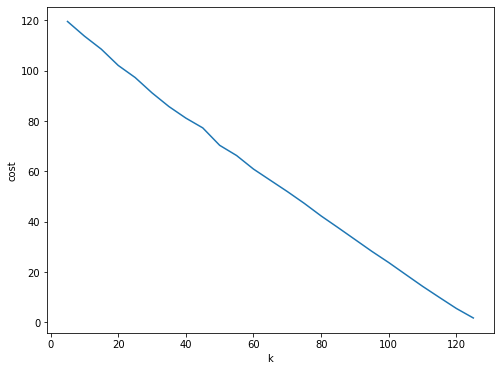

In [22]:
from pyspark.ml.clustering import KMeans
#optimize k choice over a fraction of data
n=25
cost = cost_1.copy()
for k in range(125,(n+1)*5,5):
    print(k)
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans.setWeightCol("weighCol")
    model = kmeans.fit(df)
    model.setPredictionCol("newPrediction")
    centers = model.clusterCenters()
    transformed = model.transform(df).select("features", "newPrediction")
    rows = transformed.collect()
    summary = model.summary
    cost[int(k/5 - 1)] = summary.trainingCost

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(5,(n+1)*5,5),cost)
ax.set_xlabel('k')
ax.set_ylabel('cost')


In [20]:
cost

[119.5654661,
 113.75217037,
 108.55721068,
 102.10403497,
 97.30505292,
 91.19797255,
 85.76507878,
 81.18223451,
 77.29560396699611,
 70.3701232761256,
 66.32080346385187,
 60.935400551936546,
 56.469249436314584,
 52.01451286382822,
 47.33373117207955,
 42.31596295665838,
 37.6871326947232,
 32.97492683272796,
 28.254760705039313,
 23.79800624503571,
 19.068790042530498,
 14.367591734151022,
 9.934020590335377,
 5.564482529058326,
 0.0]

In [21]:
cost_1 = cost.copy()

In [36]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(199).setSeed(1)
kmeans.setWeightCol("weighCol")
model = kmeans.fit(df)
model.setPredictionCol("newPrediction")
centers = model.clusterCenters()
transformed = model.transform(df).select("features", "newPrediction")
rows = transformed.collect()
summary = model.summary
print(summary.trainingCost)

22/06/17 16:47:43 WARN TaskSetManager: Stage 380 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:47:44 WARN TaskSetManager: Stage 381 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:47:45 WARN TaskSetManager: Stage 382 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:47:45 WARN TaskSetManager: Stage 383 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:47:45 WARN TaskSetManager: Stage 384 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:47:46 WARN TaskSetManager: Stage 385 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.
22/06/17 16:47:47 WARN TaskSetManager: Stage 387 contains a task of very large size (6649 KiB). The maximum recommended task size is 1000 KiB.

Py4JError: An error occurred while calling z:org.apache.spark.ml.python.MLSerDe.dumps

### Stop the running Spark context

In [124]:
# 
sc.stop()
spark.stop()

### Start Spark services

To start the Spark execution in the master and worker nodes, issue the following bash command on the master node:

In [ ]:
!$SPARK_HOME/sbin/start-all.sh

### Stop Spark services

To stop the Spark execution in the master and worker nodes, issue the following bash command on the master node:

In [5]:
!$SPARK_HOME/sbin/stop-all.sh

stopping org.apache.spark.deploy.worker.Worker
